In [ ]:
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from subprocess import call
import os
import math
import random
random.seed(42)

In [ ]:
# Constants
INPUT_SIGNAL_TYPES = [
    "body_acc_x_", "body_acc_y_", "body_acc_z_",
    "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
    "total_acc_x_", "total_acc_y_", "total_acc_z_"
]
LABELS = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS",
          "SITTING", "STANDING", "LAYING"]


In [ ]:
if not os.path.exists("UCI HAR Dataset.zip"):
    call(
        'wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"',
        shell=True
    )
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Skipping.\n")

extract_directory = os.path.abspath("UCI HAR Dataset")
if not os.path.exists(extract_directory):
    call(
        'unzip -nq "UCI HAR Dataset.zip"',
        shell=True
    )
    print(f"Extracted to {extract_directory}.\n")
else:
    print("Dataset already extracted. Skipping.\n")



Extracted to /content/UCI HAR Dataset.



In [ ]:
TRAIN = "UCI HAR Dataset/train/"
TEST  = "UCI HAR Dataset/test/"

def load_X(paths):
    X_signals = []
    for p in paths:
        with open(p, 'r') as f:
            series = [np.array(row.strip().split(), dtype=np.float32)
                      for row in f]
            X_signals.append(np.array(series))
    # shape -> (n_examples, signal_length, n_signals)
    return np.stack(X_signals, axis=-1)

def load_y(path):
    with open(path, 'r') as f:
        y_ = np.array([int(r.strip()) for r in f], dtype=np.int32)
    return y_ - 1

signal_files = INPUT_SIGNAL_TYPES
X_train_paths = [os.path.join(TRAIN, "Inertial Signals", f + "train.txt")
                 for f in signal_files]
X_test_paths  = [os.path.join(TEST, "Inertial Signals", f + "test.txt")
                 for f in signal_files]

X_train = load_X(X_train_paths)
X_test  = load_X(X_test_paths)
y_train = load_y(os.path.join(TRAIN, "y_train.txt"))
y_test  = load_y(os.path.join(TEST, "y_test.txt"))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (7352, 128, 9)
y_train shape: (7352,)


In [ ]:
# Cosine Annealing function
def cosine_annealing(epoch):
    min_lr = 1e-6
    return min_lr + (learning_rate - min_lr) * (1 + math.cos(math.pi * epoch / epochs)) / 2

In [ ]:
#Hyperparameters-Common for all models
n_steps = X_train.shape[1]
n_input = X_train.shape[2]
n_classes = len(LABELS)
batch_size = 128
epochs = 50
learning_rate = 0.0025
lambda_loss_amount = 0.0015
dropout_rate = 0.2

In [ ]:
# One-hot encode
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test,  num_classes=n_classes)

In [ ]:
# Prepare datasets
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
    .cache()
    .shuffle(5000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
cb_early = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
cb_lr = callbacks.LearningRateScheduler(cosine_annealing, verbose=1)
cb_reduce = callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-6)

In [ ]:
#RNN-1:2 layers of Simple RNN with dropout after every layer, Adam optimizer, categorical cross entropy loss, Callback using Early stopping and Reduce LR on Plateau

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.SimpleRNN(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.Dropout(dropout_rate)(x)
x = layers.SimpleRNN(64,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
rnn_model_1 = models.Model(inputs, logits)
rnn_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
rnn_model_1.summary()
history = rnn_model_1.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early,cb_reduce]
)
loss, acc = rnn_model_1.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = rnn_model_1.predict(test_ds)
rnn_1_y_pred = np.argmax(y_proba, axis=1)
y_true = y_test
print(metrics.classification_report(
    y_true, rnn_1_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128, 128)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,406 (118.77 KB)

 Trainable params: 30,406 (118.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 550ms/step - accuracy: 0.4602 - loss: 1.4509 - val_accuracy: 0.5931 - val_loss: 1.1422 - learning_rate: 0.0025
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 37s 534ms/step - accuracy: 0.6407 - loss: 0.9275 - val_accuracy: 0.6644 - val_loss: 1.0386 - learning_rate: 0.0025
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 516ms/step - accuracy: 0.6900 - loss: 0.8387 - val_accuracy: 0.5517 - val_loss: 1.1857 - learning_rate: 0.0025
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 518ms/step - accuracy: 0.6548 - loss: 0.9346 - val_accuracy: 0.6956 - val_loss: 0.8253 - learning_rate: 0.0025
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 511ms/step - accuracy: 0.7178 - loss: 0.7689 - val_accuracy: 0.5738 - val_loss: 1.2423 - learning_rate: 0.0025
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 511ms/step - accuracy: 0.5759 - loss: 1.0963 - val_accuracy: 0.6081 - val_loss: 1.0424 - learning_rate: 0.0025
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 513ms/step - accuracy: 0.6374 - loss: 0.

In [ ]:
#RNN-2: Building up on RNN-1, this model has Layer normalization after every RNN layer, and implements Cosine Annealing instead of Reduce LR on Plateau

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.SimpleRNN(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.SimpleRNN(64,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
rnn_model_2 = models.Model(inputs, logits)
rnn_model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
rnn_model_2.summary()
history = rnn_model_2.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early,cb_lr]
)
loss, acc = rnn_model_2.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = rnn_model_2.predict(test_ds)
rnn_2_y_pred  = np.argmax(y_proba, axis=1)
y_true  = y_test
print(metrics.classification_report(
    y_true, rnn_2_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 128, 128)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,790 (120.27 KB)

 Trainable params: 30,790 (120.27 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 620ms/step - accuracy: 0.3883 - loss: 1.7552 - val_accuracy: 0.5925 - val_loss: 1.1710 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.5887 - loss: 1.1150 - val_accuracy: 0.6464 - val_loss: 0.9882 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 545ms/step - accuracy: 0.5476 - loss: 1.2028 - val_accuracy: 0.5697 - val_loss: 1.1949 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 564ms/step - accuracy: 0.6054 - loss: 1.0457 - val_accuracy: 0.6522 - val_loss: 0.9460 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoc

In [ ]:
#RNN-3: Builds on the previous RNN-2 model, adding a 3rd layer of the RNN model, adding gaussian noise to the inputs of the model, and capping the L2 norm of gradients during ADAM optimization to 1.0

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.GaussianNoise(0.1)(inputs)
x = layers.SimpleRNN(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.SimpleRNN(64,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.SimpleRNN(32,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
rnn_model_3 = models.Model(inputs, logits)
rnn_model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
rnn_model_3.summary()
history = rnn_model_3.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early,cb_lr]
)
loss, acc = rnn_model_3.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = rnn_model_3.predict(test_ds)
rnn_3_y_pred  = np.argmax(y_proba, axis=1)
y_true  = y_test
print(metrics.classification_report(
    y_true, rnn_3_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 128, 128)       │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 128, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 128, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,766 (131.90 KB)

 Trainable params: 33,766 (131.90 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 826ms/step - accuracy: 0.2735 - loss: 2.1719 - val_accuracy: 0.3359 - val_loss: 1.6499 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 700ms/step - accuracy: 0.3399 - loss: 1.6980 - val_accuracy: 0.4398 - val_loss: 1.5826 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 683ms/step - accuracy: 0.3616 - loss: 1.6304 - val_accuracy: 0.3773 - val_loss: 1.5574 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 41s 701ms/step - accuracy: 0.3755 - loss: 1.5753 - val_accuracy: 0.3879 - val_loss: 1.5715 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoc

In [ ]:
#GRU-1: GRU Model with the same structure and characteristics as RNN-1 model

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.GRU(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.Dropout(dropout_rate)(x)
x = layers.GRU(64,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
gru_model_1 = models.Model(inputs, logits)
gru_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
gru_model_1.summary()
history = gru_model_1.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_reduce]
)
loss, acc = gru_model_1.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = gru_model_1.predict(test_ds)
gru_1_y_pred  = np.argmax(y_proba, axis=1)
y_true  = y_test
print(metrics.classification_report(
    y_true, gru_1_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,014 (355.52 KB)

 Trainable params: 91,014 (355.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 926ms/step - accuracy: 0.4199 - loss: 1.5375 - val_accuracy: 0.5059 - val_loss: 1.2358 - learning_rate: 0.0025
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 83s 977ms/step - accuracy: 0.6707 - loss: 0.8797 - val_accuracy: 0.8493 - val_loss: 0.5289 - learning_rate: 0.0025
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 51s 883ms/step - accuracy: 0.9061 - loss: 0.3518 - val_accuracy: 0.9013 - val_loss: 0.4169 - learning_rate: 0.0025
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 53s 920ms/step - accuracy: 0.9385 - loss: 0.2455 - val_accuracy: 0.8873 - val_loss: 0.4176 - learning_rate: 0.0025
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 84s 954ms/step - accuracy: 0.9375 - loss: 0.2370 - val_accuracy: 0.8955 - val_loss: 0.4146 - learning_rate: 0.0025
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 902ms/step - accuracy: 0.9429 - loss: 0.1997 - val_accuracy: 0.8829 - val_loss: 0.4516 - learning_rate: 0.0025
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 85s 954ms/step - accuracy: 0.9457 - loss: 0.

In [ ]:
# GRU-2: GRU version of RNN-2

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.GRU(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.GRU(64,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
gru_model_2 = models.Model(inputs, logits)
gru_model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
gru_model_2.summary()
history = gru_model_2.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_lr]
)
loss, acc = gru_model_2.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = gru_model_2.predict(test_ds)
gru_2_y_pred  = np.argmax(y_proba, axis=1)
y_true  = y_test
print(metrics.classification_report(
    y_true, gru_2_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_6           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,398 (357.02 KB)

 Trainable params: 91,398 (357.02 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5298 - loss: 1.5581 - val_accuracy: 0.8344 - val_loss: 0.6519 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 75s 954ms/step - accuracy: 0.8931 - loss: 0.4788 - val_accuracy: 0.8965 - val_loss: 0.4615 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 54s 934ms/step - accuracy: 0.9356 - loss: 0.3234 - val_accuracy: 0.8931 - val_loss: 0.3902 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 54s 933ms/step - accuracy: 0.9485 - loss: 0.2547 - val_accuracy: 0.9175 - val_loss: 0.3447 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoch 5

In [ ]:
#GRU-3: GRU version of RNN-3

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.GaussianNoise(stddev=0.1)(inputs)
x = layers.GRU(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.GRU(64,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.GRU(32,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes,kernel_regularizer=regularizers.l2(lambda_loss_amount),)(x)
gru_model_3 = models.Model(inputs, logits)
gru_model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
gru_model_3.summary()
history = gru_model_3.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_lr]
)
loss, acc = gru_model_3.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

y_proba = gru_model_3.predict(test_ds)
gru_3_y_pred  = np.argmax(y_proba, axis=1)
y_true  = y_test
print(metrics.classification_report(
    y_true, gru_3_y_pred, target_names=LABELS, digits=4, zero_division=0
))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 128, 9)         │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_7           │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 128, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,678 (393.27 KB)

 Trainable params: 100,678 (393.27 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.5726 - loss: 1.4326 - val_accuracy: 0.8741 - val_loss: 0.6107 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9070 - loss: 0.4989 - val_accuracy: 0.9237 - val_loss: 0.3895 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9469 - loss: 0.3316 - val_accuracy: 0.9169 - val_loss: 0.3296 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9470 - loss: 0.2829 - val_accuracy: 0.9233 - val_loss: 0.3025 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoch 5/50
58/5

In [ ]:
#LSTM-1: LSTM Model with the same structure and characteristics as RNN-1 model

In [ ]:
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.Dropout(dropout_rate)(x)
x = layers.LSTM(64, kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes, kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
lstm_model_1 = models.Model(inputs, logits)
lstm_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
lstm_model_1.summary()
history = lstm_model_1.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_reduce]
)
loss, acc = lstm_model_1.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = lstm_model_1.predict(test_ds)
lstm_1_y_pred = np.argmax(y_proba, axis=1)
y_true = y_test
print(metrics.classification_report(
    y_true, lstm_1_y_pred, target_names=LABELS, digits=4, zero_division=0))

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,454 (470.52 KB)

 Trainable params: 120,454 (470.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4618 - loss: 1.4696 - val_accuracy: 0.5762 - val_loss: 1.0422 - learning_rate: 0.0025
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.6597 - loss: 0.8830 - val_accuracy: 0.7044 - val_loss: 0.8564 - learning_rate: 0.0025
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6572 - loss: 0.8566 - val_accuracy: 0.6980 - val_loss: 0.8258 - learning_rate: 0.0025
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7698 - loss: 0.6758 - val_accuracy: 0.7713 - val_loss: 0.6886 - learning_rate: 0.0025
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8426 - loss: 0.5228 - val_accuracy: 0.7693 - val_loss: 0.7163 - learning_rate: 0.0025
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8540 - loss: 0.5082 - val_accuracy: 0.8521 - val_loss: 0.5980 - learning_rate: 0.0025
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9173 - loss: 0.3437 - val_accuracy: 

In [ ]:
#LSTM-2- LSTM Version of RNN-2

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.LSTM(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount))(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.LSTM(64, kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes, kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
lstm_model_2 = models.Model(inputs, logits)
lstm_model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
lstm_model_2.summary()
history = lstm_model_2.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_lr]
)
loss, acc = lstm_model_2.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = lstm_model_2.predict(test_ds)
lstm_2_y_pred = np.argmax(y_proba, axis=1)
y_true = y_test
print(metrics.classification_report(
    y_true, lstm_2_y_pred, target_names=LABELS, digits=4, zero_division=0))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,838 (472.02 KB)

 Trainable params: 120,838 (472.02 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5253 - loss: 1.5235 - val_accuracy: 0.7357 - val_loss: 0.9567 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8407 - loss: 0.6800 - val_accuracy: 0.8683 - val_loss: 0.6365 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9302 - loss: 0.3918 - val_accuracy: 0.8809 - val_loss: 0.5500 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9377 - loss: 0.3207 - val_accuracy: 0.8962 - val_loss: 0.4880 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoch 5/50
58/58

In [ ]:
#LSTM-3: LSTM version of RNN-3

In [ ]:
inputs = layers.Input(shape=(n_steps, n_input))
x = layers.GaussianNoise(0.1)(inputs)
x = layers.LSTM(128,return_sequences=True,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.LSTM(64,return_sequences=True, kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.LSTM(32,kernel_regularizer=regularizers.l2(lambda_loss_amount),recurrent_dropout=0.2)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
logits = layers.Dense(n_classes, kernel_regularizer=regularizers.l2(lambda_loss_amount))(x)
lstm_model_3 = models.Model(inputs, logits)
lstm_model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,clipnorm=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
    jit_compile=True
)
lstm_model_3.summary()
history = lstm_model_3.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[cb_early, cb_lr]
)
loss, acc = lstm_model_3.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
y_proba = lstm_model_3.predict(test_ds)
lstm_3_y_pred = np.argmax(y_proba, axis=1)
y_true = y_test
print(metrics.classification_report(
    y_true, lstm_3_y_pred, target_names=LABELS, digits=4, zero_division=0))

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 128, 9)         │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 128, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 128, 64)        │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,126 (520.02 KB)

 Trainable params: 133,126 (520.02 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1: LearningRateScheduler setting learning rate to 0.0025.
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5485 - loss: 1.6280 - val_accuracy: 0.8371 - val_loss: 0.7927 - learning_rate: 0.0025

Epoch 2: LearningRateScheduler setting learning rate to 0.0024975343971711255.
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8939 - loss: 0.6566 - val_accuracy: 0.8962 - val_loss: 0.5817 - learning_rate: 0.0025

Epoch 3: LearningRateScheduler setting learning rate to 0.0024901473192924404.
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9297 - loss: 0.4712 - val_accuracy: 0.8901 - val_loss: 0.5957 - learning_rate: 0.0025

Epoch 4: LearningRateScheduler setting learning rate to 0.002477867919785497.
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9402 - loss: 0.3779 - val_accuracy: 0.9030 - val_loss: 0.4976 - learning_rate: 0.0025

Epoch 5: LearningRateScheduler setting learning rate to 0.0024607446598302247.
Epoch 5/50
58

In [ ]:
models_=["rnn_model_1","rnn_model_2","rnn_model_3","gru_model_1","gru_model_2","gru_model_3","lstm_model_1","lstm_model_2","lstm_model_3"]
predictions_=[rnn_1_y_pred,rnn_2_y_pred,rnn_3_y_pred,gru_1_y_pred,gru_2_y_pred,gru_3_y_pred,lstm_1_y_pred,lstm_2_y_pred,lstm_3_y_pred]

results=[]
for model_name,model_prediction in zip(models_,predictions_):
  results.append(
      {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, model_prediction),
        'Precision': precision_score(y_true, model_prediction, average='macro'),
        'Recall': recall_score(y_true, model_prediction, average='macro'),
        'F1-Score': f1_score(y_true, model_prediction, average='macro')
    }
  )

df_results = pd.DataFrame(results)
print(df_results)

          Model  Accuracy  Precision    Recall  F1-Score
0   rnn_model_1  0.718697   0.743337  0.708125  0.685735
1   rnn_model_2  0.652189   0.671801  0.640137  0.644871
2   rnn_model_3  0.434001   0.378251  0.425340  0.345199
3   gru_model_1  0.894808   0.902739  0.896195  0.894182
4   gru_model_2  0.913132   0.913964  0.915095  0.913898
5   gru_model_3  0.937564   0.938258  0.939049  0.938391
6  lstm_model_1  0.905667   0.907214  0.908003  0.906740
7  lstm_model_2  0.906006   0.908193  0.906437  0.904996
8  lstm_model_3  0.909060   0.910562  0.911153  0.910666


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


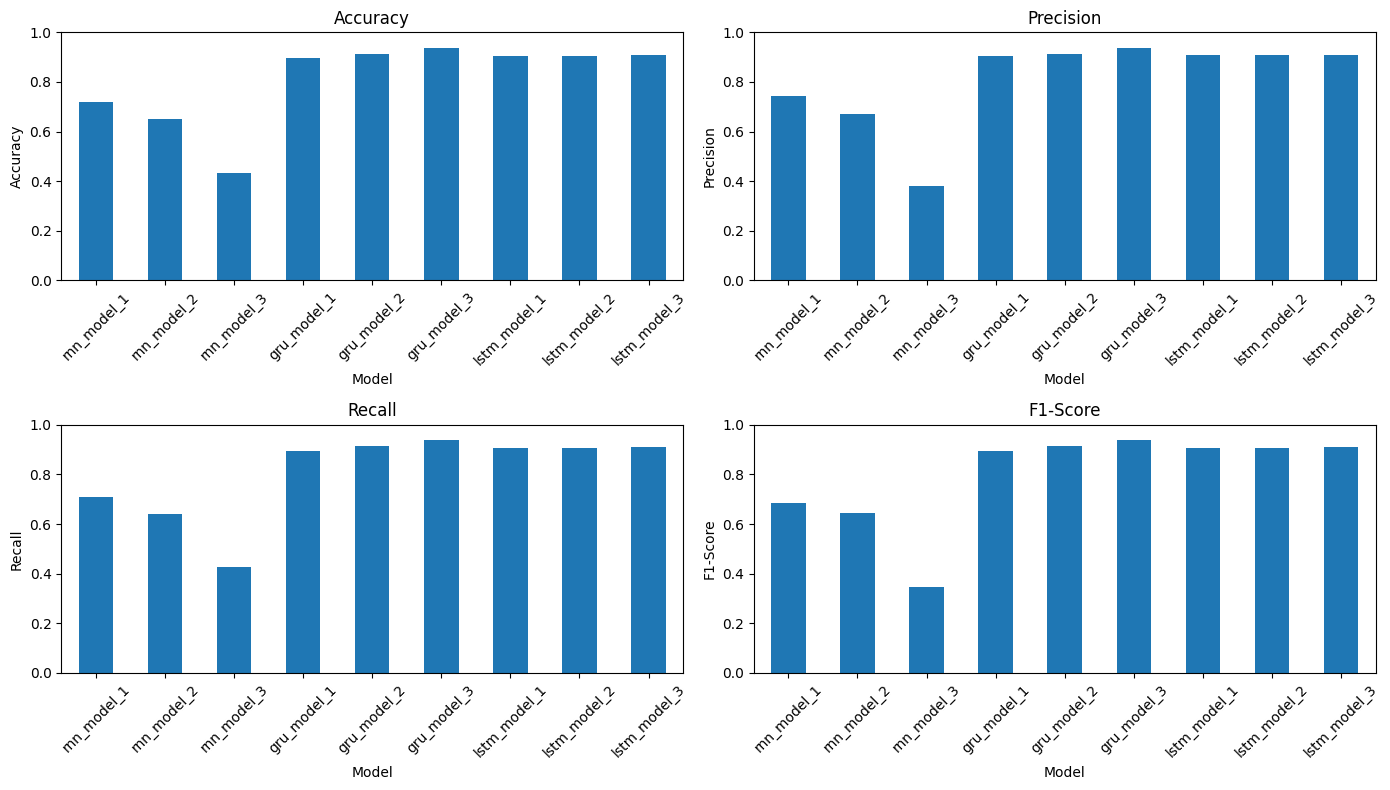

In [ ]:
df_results.set_index('Model', inplace=True)

# Plot bar charts for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plt.figure(figsize=(14, 8))
for idx, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, idx)
    df_results[metric].plot(kind='bar')
    plt.title(metric)
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()